In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, avg, when, isnull, isnan
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("unit26").getOrCreate()

In [3]:
df = spark.read.option("header", "true").csv("retail_edited.csv")

In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
for col_name in df.columns:
    null_count = df.where((col(col_name).isNull()) | (isnan(col(col_name)))).count()
    print(f"{col_name}, Null Count: {null_count}")

In [ ]:
df.show(5)

In [8]:
customer_metrics = df.groupBy("CustomerID") \
    .agg(
        count("InvoiceNo").alias("TotalOrders"),
        sum("Quantity").alias("TotalQuantity"),
        avg("Quantity").alias("AvgOrderQuantity")
    )

In [9]:
# feature vector assembler
fcols = customer_metrics.columns[1:]
assem = VectorAssembler(inputCols=fcols, outputCol="features")
adat = assem.transform(customer_metrics)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
smodel = scaler.fit(adat)

In [10]:
# K-means clustering
kmeans = KMeans(k=3, seed=1)  # Adjust k as needed
model = kmeans.fit(smodel.transform(adat))


In [11]:
p = model.transform(smodel.transform(adat))

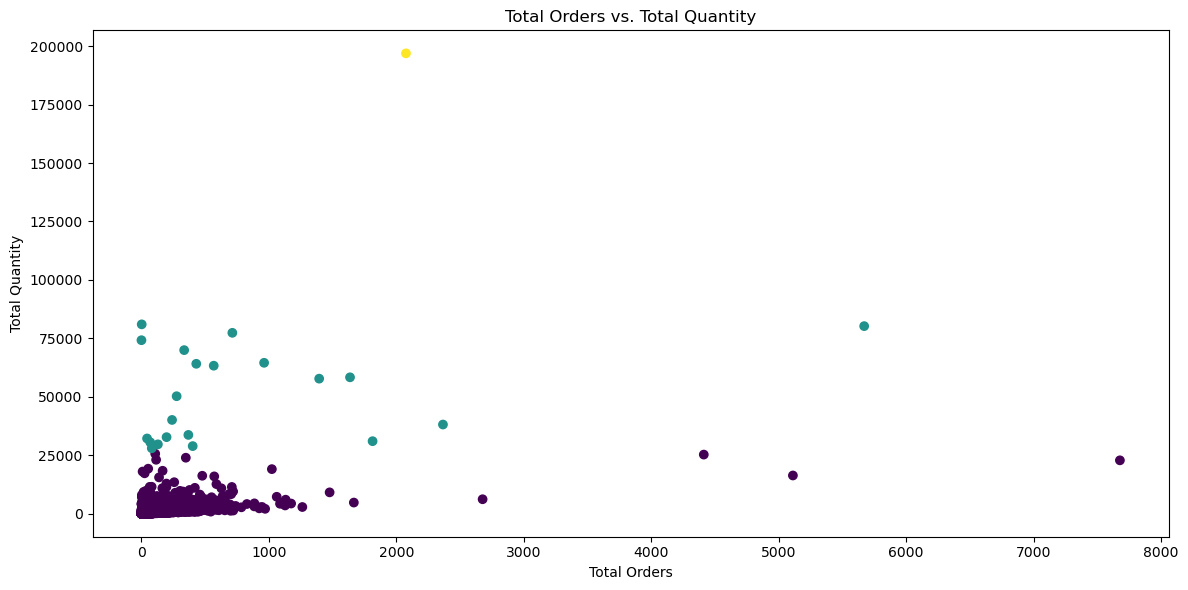

In [13]:
# TotalOrders vs. TotalQuantity
plt.figure(figsize=(12, 6))
plt.scatter(
    p.select("TotalOrders").collect(),
    p.select("TotalQuantity").collect(),
    c=p.select("prediction").collect(),
    cmap="viridis"
)
plt.xlabel("Total Orders")
plt.ylabel("Total Quantity")
plt.title("Total Orders vs. Total Quantity")

plt.tight_layout()
plt.show()

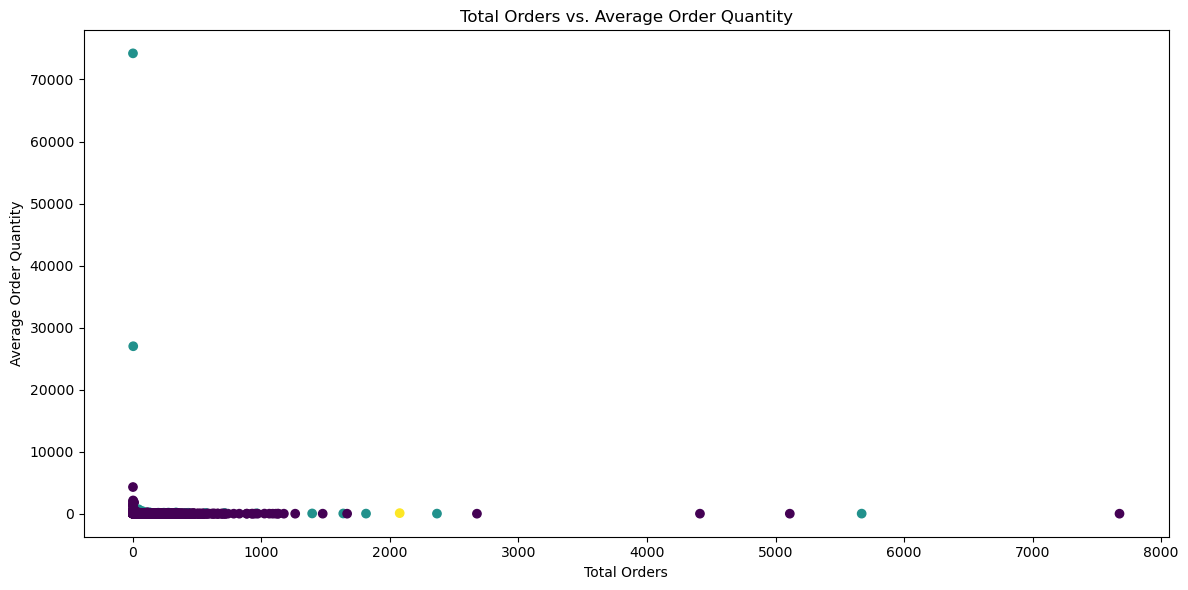

In [14]:
# TotalOrders vs. AvgOrderQuantity
plt.figure(figsize=(12, 6))
plt.scatter(
    p.select("TotalOrders").collect(),
    p.select("AvgOrderQuantity").collect(),
    c=p.select("prediction").collect(),
    cmap="viridis"
)
plt.xlabel("Total Orders")
plt.ylabel("Average Order Quantity")
plt.title("Total Orders vs. Average Order Quantity")

plt.tight_layout()
plt.show()